# Laden der Daten

In [1]:
# load vine dataset from scikit-learn

from sklearn.datasets import load_wine
import pandas as pd
# import train test split
from sklearn.model_selection import train_test_split
import torch

data = load_wine()
X = data.data

print(data.feature_names)

df = pd.DataFrame(X, columns=data.feature_names)
df.head()

y = df['alcohol']
df = df.drop("alcohol", axis=1)
df.head()

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# Scaling der Daten

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=data.feature_names[:-1])
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines
0,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


# Split der daten und Konvertierung in Tensoren

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [4]:
x_train = torch.tensor(x_train.values, dtype=torch.float)
x_test = torch.tensor(x_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test= torch.tensor(y_test.values, dtype=torch.float)

In [5]:
x_train.shape

torch.Size([142, 12])

In [6]:
y_train.shape

torch.Size([142])

# Überlegungen zur Netzarchitektur

* Wir haben 12 Attribute / Spalten / Features
* Wir haben 142 Traingsbeispiele

Angenommen, zwei HiddenLayer, erstmal 70, dann 30 Neuronen
* w1: von 12 auf 70
* w2: von 70 auf 30
* w3: von 30 auf 1

In [21]:
def batch_norm(x):
    mean = x.mean()
    std = x.std()
    return (x - mean) / std

# Was bewirkt batch norm?
# --> Normalisierung der Outputs der Neuronen
# --> Wirkt sich positiv auf das Training aus

# Warum?
# --> Wirkt sich positiv auf die Gradienten aus, da diese nicht mehr so starke Schwankungen haben
# vorher [0.2, 0.7, 213123.2, 123.3]
vorher=torch.tensor([0.2, 0.7, 213123.2, 123.3])
print(batch_norm(vorher))
# nachher: [-0.5004, -0.5004,  1.5000, -0.4992]

# Wie?
# --> Durch die Normalisierung der Outputs der Neuronen, werden die Outputs der Neuronen in einem ähnlichen Bereich liegen

# Wie wird das erreicht?
# --> Durch die Subtraktion des Mittelwerts und die Division durch die Standardabweichung. Das Ergebnis ist eine Standardnormalverteilung. Dies ist eine Normalverteilung mit Mittelwert 0 und Standardabweichung 1.

# In der Folge können auch tiefere Netze trainiert werden, da die Gradienten nicht mehr so stark schwanken. Außerdem wird das Vanishing Gradient Problem verhindert.

def forward(x):
    a2= torch.relu(x @ w1 + b1)
    # batch norm
    a2 = batch_norm(a2)   # 70 Neuronen, bzw. ein Tensor mit Shape(70,1)
    a3 = torch.relu(a2 @ w2 + b2)
    # batch norm
    a3 = batch_norm(a3)   # 30 Neuronen
    a4 = torch.relu(a3 @ w3 + b3)
    y_hat = a4
    return y_hat

tensor([-0.5004, -0.5004,  1.5000, -0.4992])


# Training

  0%|          | 0/50 [00:00<?, ?it/s]

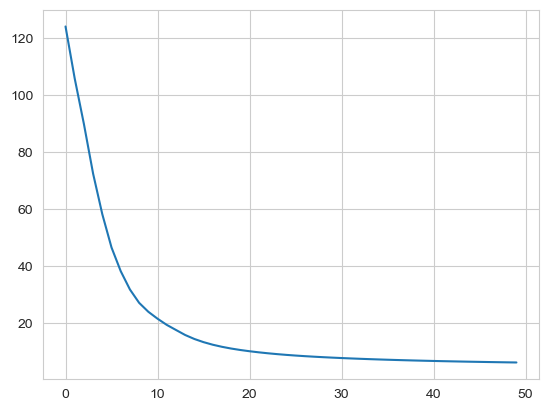

In [17]:
w1 = torch.normal(size=(12, 70), std=1.0, mean=0.0, requires_grad=True)
w2 = torch.normal(size=(70, 30), std=1.0, mean=0.0, requires_grad=True)
w3 = torch.normal(size=(30, 1), std=1.0, mean=0.0, requires_grad=True)
b1 = torch.tensor(0.0, requires_grad=True)
b2 = torch.tensor(0.0, requires_grad=True)
b3 = torch.tensor(0.0, requires_grad=True)
lr=0.0001
weight_decay=0.001

def train(single_x, single_y):
    y_hat=forward(single_x)
    loss = (y_hat - single_y)**2 + weight_decay * (w1**2).sum() + weight_decay * (w2**2).sum() + weight_decay * (w3**2).sum()
    loss.backward()
    with torch.no_grad():
        w1.sub_(w1.grad * lr)
        w2.sub_(w2.grad * lr)
        w3.sub_(w3.grad * lr)
        b1.sub_(b1.grad * lr)
        b2.sub_(b2.grad * lr)
        b3.sub_(b3.grad * lr)
        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()
    return loss.item()

losses=[]
# import tqdm notebook
from tqdm.notebook import tqdm
for epoch in tqdm(range(50)):
    loss_sum=0
    for i in range(len(x_train)):
        loss_sum += train(x_train[i], y_train[i])
    losses.append(loss_sum/len(x_train))

#plot
import matplotlib.pyplot as plt
plt.plot(losses)

# Auswertung

In [18]:
errorSum=0
for i in range(len(x_test)):
    y_hat=forward(x_test[i])
    y = y_test[i]
    errorSum += torch.abs(y_hat - y)

print("mean absolute error:" , errorSum/len(x_test))

mean absolute error: tensor([1.9900], grad_fn=<DivBackward0>)


In [19]:
for i in range(10):
    y_hat=forward(x_test[i])
    y = y_test[i]
    print("y_hat: ", y_hat, "y: ", y)

y_hat:  tensor([17.0267], grad_fn=<ReluBackward0>) y:  tensor(13.6400)
y_hat:  tensor([6.6579], grad_fn=<ReluBackward0>) y:  tensor(14.2100)
y_hat:  tensor([11.1458], grad_fn=<ReluBackward0>) y:  tensor(12.9300)
y_hat:  tensor([13.7669], grad_fn=<ReluBackward0>) y:  tensor(13.7300)
y_hat:  tensor([7.7842], grad_fn=<ReluBackward0>) y:  tensor(12.3700)
y_hat:  tensor([13.0485], grad_fn=<ReluBackward0>) y:  tensor(14.3000)
y_hat:  tensor([10.5340], grad_fn=<ReluBackward0>) y:  tensor(12.)
y_hat:  tensor([14.1440], grad_fn=<ReluBackward0>) y:  tensor(13.4000)
y_hat:  tensor([11.9253], grad_fn=<ReluBackward0>) y:  tensor(11.6100)
y_hat:  tensor([11.1600], grad_fn=<ReluBackward0>) y:  tensor(13.3600)
